# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Подгружаем данные

In [2]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2022-09-27 15:22:47--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  --.-KB/s    in 0.08s   

2022-09-27 15:22:47 (66.5 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2022-09-27 15:22:47--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28

In [3]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

Описание данных

In [4]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


Семплы и размеры выборок

In [5]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [6]:
train_df.shape

(32395, 37)

In [7]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,...,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,...,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,...,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,...,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [8]:
test_df.shape

(200, 36)

Количество разных типов фичей

In [9]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

Уровень дефолт-рейта в выборке = 6,7219%

In [10]:
train_df['default_12m'].values.mean()

0.06454699799351751

In [11]:
train_df.record_id.nunique()

32395

32395 уникальных наблюдений

### Строим бэйзлайн модель c 3-ми фичами

In [12]:
features = ['bus_age','ul_capital_sum', 'ul_founders_cnt']

In [13]:
features_df = train_df.loc[:,features]
features_df['default_12m'] = train_df['default_12m']

In [14]:
features_df.head()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
0,198,50000.0,2,0
1,256,10000.0,5,0
2,33,10000.0,2,0
3,185,300000.0,1,0
4,220,10000.0,2,0


### Построим карту коллеряций

In [15]:
features_df.corr()

,bus_age,ul_capital_sum,ul_founders_cnt,default_12m
bus_age,1.000000,0.066929,0.209451,-0.109389
ul_capital_sum,0.066929,1.000000,0.029165,-0.019452
ul_founders_cnt,0.209451,0.029165,1.000000,-0.023244
default_12m,-0.109389,-0.019452,-0.023244,1.000000


### Валидация результата

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_df.drop('default_12m',axis=1),
                                                    features_df['default_12m'],
                                                    random_state=42, shuffle=True)

logit = LogisticRegression(C=1,solver='lbfgs',max_iter=1000)
cv_baseline = cross_val_score(logit, X_train, y_train, cv=5, scoring='roc_auc').mean()
cv_baseline

0.6483643068016243

ROC/AUC бэйзлайн модели - 64,83%

### Построение модели на всех данных

In [17]:
logit.fit(features_df.drop('default_12m',axis=1), features_df['default_12m'])

LogisticRegression(C=1, max_iter=1000)

### Формирование файла с ответом

In [18]:
answ_df = test_df[['record_id']]

In [19]:
answ_df['id'] = answ_df['record_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:

answ_df.drop('record_id',axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
cutoff = y_train.mean()

In [22]:
answ_df['predict'] = (logit.predict_proba(test_df.loc[:,features])[:,1]>cutoff).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

In [24]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords-new/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)

### Моя работа

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
from scipy import stats

Классы не сбалансированны

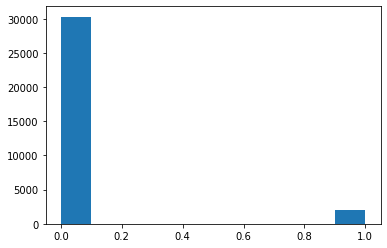

In [26]:
plt.hist(train_df['default_12m'])
plt.show()   

Проверю признаки на нормальность

In [27]:
for i in train_df.drop(['ul_staff_range'], axis = 1).columns:
  print(i, stats.shapiro(train_df[i]))

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


record_id ShapiroResult(statistic=0.9546059370040894, pvalue=0.0)
ar_revenue ShapiroResult(statistic=nan, pvalue=1.0)
ar_total_expenses ShapiroResult(statistic=nan, pvalue=1.0)
ar_sale_cost ShapiroResult(statistic=nan, pvalue=1.0)
ar_selling_expenses ShapiroResult(statistic=nan, pvalue=1.0)
ar_management_expenses ShapiroResult(statistic=nan, pvalue=1.0)
ar_sale_profit ShapiroResult(statistic=nan, pvalue=1.0)
ar_balance_of_rvns_and_expns ShapiroResult(statistic=nan, pvalue=1.0)
ar_profit_before_tax ShapiroResult(statistic=nan, pvalue=1.0)
ar_taxes ShapiroResult(statistic=nan, pvalue=1.0)
ar_other_profit_and_losses ShapiroResult(statistic=nan, pvalue=1.0)
ar_net_profit ShapiroResult(statistic=nan, pvalue=1.0)
ab_immobilized_assets ShapiroResult(statistic=nan, pvalue=1.0)
ab_mobile_current_assets ShapiroResult(statistic=nan, pvalue=1.0)
ab_inventory ShapiroResult(statistic=nan, pvalue=1.0)
ab_accounts_receivable ShapiroResult(statistic=nan, pvalue=1.0)
ab_other_current_assets ShapiroResul

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [28]:
not_norm_feach = ['bus_age', 'ogrn_age', 'adr_actual_age', 'head_actual_age', 'cap_actual_age', 'ul_capital_sum', 'ul_founders_cn', 'ul_branch_cnt', 'ul_strategic_flg']
norm_feach = ['ar_revenue',
 'ar_management_expenses',
 'ar_net_profit',
 'record_id',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_long_term_liabilities',
 'ab_accounts_receivable',
 'ul_founders_cnt',
 'ar_profit_before_tax',
 'ab_cash_and_securities',
 'ab_own_capital',
 'ab_borrowed_capital',
 'ar_sale_cost',
 'ab_other_borrowings',
 'ar_sale_profit',
 'ar_total_expenses',
 'ab_other_current_assets',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ab_losses',
 'ar_selling_expenses',
 'ul_systematizing_flg',
 'ab_short_term_borrowing',
 'ab_inventory',
 'ar_balance_of_rvns_and_expns',
 'ab_accounts_payable']

Проведу диспресионный анализ с трейном и тестом, проведу отбор признаков

In [29]:
for i in norm_feach:
  print(i, stats.f_oneway(train_df[i].dropna(), test_df.dropna()[i]))

ar_revenue F_onewayResult(statistic=0.11175311691884997, pvalue=0.7381610423218125)
ar_management_expenses F_onewayResult(statistic=1.845071468918922, pvalue=0.17437538310139195)
ar_net_profit F_onewayResult(statistic=0.07846727007799659, pvalue=0.779388708096403)
record_id F_onewayResult(statistic=0.003358907724731897, pvalue=0.9537839657948298)
ab_immobilized_assets F_onewayResult(statistic=0.014454020181279345, pvalue=0.904306408261559)
ab_mobile_current_assets F_onewayResult(statistic=0.26526436855336316, pvalue=0.6065328811141789)
ab_long_term_liabilities F_onewayResult(statistic=0.2804265430511945, pvalue=0.596428564957441)
ab_accounts_receivable F_onewayResult(statistic=0.03218851689066133, pvalue=0.8576166328126035)
ul_founders_cnt F_onewayResult(statistic=0.02538062344815004, pvalue=0.87342329084506)
ar_profit_before_tax F_onewayResult(statistic=0.06386427621863909, pvalue=0.8004923627755307)
ab_cash_and_securities F_onewayResult(statistic=0.4416384240109131, pvalue=0.50634155

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [30]:
new_feach = ['ar_revenue',
 'ar_net_profit',
 'record_id',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_long_term_liabilities',
 'ab_accounts_receivable',
 'ul_founders_cnt',
 'ar_profit_before_tax',
 'ab_cash_and_securities',
 'ab_borrowed_capital',
 'ar_sale_cost',
 'ab_other_borrowings',
 'ar_sale_profit',
 'ar_total_expenses',
 'ab_other_current_assets',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ab_losses',
 'ar_selling_expenses',
 'ab_inventory',
 'ar_balance_of_rvns_and_expns',
 'ab_accounts_payable']

In [31]:
new_feach.append('default_12m')

In [32]:
new_train_na = train_df[new_feach]

In [33]:
new_train_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ar_revenue                    17250 non-null  float64
 1   ar_net_profit                 17250 non-null  float64
 2   record_id                     32395 non-null  int64  
 3   ab_immobilized_assets         17250 non-null  float64
 4   ab_mobile_current_assets      17250 non-null  float64
 5   ab_long_term_liabilities      17250 non-null  float64
 6   ab_accounts_receivable        17250 non-null  float64
 7   ul_founders_cnt               32395 non-null  int64  
 8   ar_profit_before_tax          17250 non-null  float64
 9   ab_cash_and_securities        17250 non-null  float64
 10  ab_borrowed_capital           17250 non-null  float64
 11  ar_sale_cost                  17250 non-null  float64
 12  ab_other_borrowings           17250 non-null  float64
 13  a

Ввиду малого кол-ва признаков без пропусков, удалю строки с пропусками

In [34]:
new_train = new_train_na.dropna()

In [455]:
X_df = new_train.drop('default_12m',axis=1)
y_df = new_train['default_12m']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state=42, shuffle=True)

Построю тестовую модель 

In [456]:
model = RandomForestClassifier(max_depth = 10)

In [457]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [458]:
print('train', roc_auc_score(model.predict(X_train), y_train))
print('test', roc_auc_score(model.predict(X_test), y_test))

train 0.9781708557315124
test 0.9772199651770168


Довольно неплохой результат, проверим на заполненных средним данных

In [39]:
all_na_train = new_train_na[new_train_na['ar_net_profit'].isna() == True]

In [40]:
fillna_train = all_na_train.fillna(pd.concat([train_df, test_df]).mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [41]:
X_temp = fillna_train.drop('default_12m', axis = 1)
y_temp = fillna_train['default_12m']

In [42]:
model.predict(X_temp).sum()

0

Модель ПЛОХО работает на незаполненных данных

In [43]:
model.feature_importances_

array([0.0558506 , 0.05480195, 0.09023038, 0.0152962 , 0.0599116 ,
       0.01662885, 0.05468077, 0.01709183, 0.05535678, 0.06154165,
       0.05424378, 0.05538118, 0.0114097 , 0.05314058, 0.0578012 ,
       0.01183966, 0.04162339, 0.00586746, 0.05461652, 0.01309493,
       0.0584002 , 0.04841029, 0.05278048])

Это же подтверждается feature_importances

Построю модель на сбалансированных данных

In [460]:
balanced_train = pd.concat([new_train[new_train['default_12m'] == 1], new_train[new_train['default_12m'] == 0].sample(2400)])

In [461]:
X_df = balanced_train.drop('default_12m',axis=1)
y_df = balanced_train['default_12m']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state=42, shuffle=True)

In [462]:
balanced_model = RandomForestClassifier(max_depth = 10)

In [463]:
balanced_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [464]:
print('train', roc_auc_score(balanced_model.predict(X_train), y_train))
print('test', roc_auc_score(balanced_model.predict(X_test), y_test))

train 0.9229753521126761
test 0.7064935064935065


Учитывая что тест выборка довольно маленькая, посмотрим метрику на всех данных

In [465]:
roc_auc_score(balanced_model.predict(new_train.drop('default_12m', axis = 1)), new_train['default_12m'])

0.7477505472813841

In [466]:
balanced_model.predict(X_temp).sum()

0

Обе модели дают плохой результат на данных с пропусками, построю отдельную модель для таких данных

In [467]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32395 entries, 0 to 32394
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_id                     32395 non-null  int64  
 1   ar_revenue                    17250 non-null  float64
 2   ar_total_expenses             17250 non-null  float64
 3   ar_sale_cost                  17250 non-null  float64
 4   ar_selling_expenses           17250 non-null  float64
 5   ar_management_expenses        17250 non-null  float64
 6   ar_sale_profit                17250 non-null  float64
 7   ar_balance_of_rvns_and_expns  17250 non-null  float64
 8   ar_profit_before_tax          17250 non-null  float64
 9   ar_taxes                      17250 non-null  float64
 10  ar_other_profit_and_losses    17250 non-null  float64
 11  ar_net_profit                 17250 non-null  float64
 12  ab_immobilized_assets         17250 non-null  float64
 13  a

In [516]:
feach_for_na = ['bus_age',
                'ogrn_age',
                'adr_actual_age',
                'head_actual_age',
                'cap_actual_age',
                'ul_capital_sum',
                'ul_founders_cnt',
                'ul_branch_cnt',
                'ul_strategic_flg',
                'ul_systematizing_flg',
                'default_12m']

In [469]:
na_train = train_df[feach_for_na]

In [471]:
na_train = pd.concat([na_train[na_train['default_12m'] == 1], na_train[na_train['default_12m'] == 0].sample(4000)])

In [476]:
X_df = na_train.drop('default_12m',axis=1)
y_df = na_train['default_12m']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state=42, shuffle=True)

In [483]:
na_model = RandomForestClassifier(n_estimators = 30, max_depth = 10, criterion = 'gini')

In [484]:
na_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=30)

In [485]:
print('test', roc_auc_score(na_model.predict(X_test), y_test))
print('test', roc_auc_score(na_model.predict(X_train), y_train))

test 0.6305396635641705
test 0.7899584294856058


In [632]:
from tqdm import tqdm

Довольно неплохо, напишем функцию full_predict для предсказаний

In [643]:
def full_predict(df, model1, model2, feach_for_na, new_feach):
  ans = []
  for i in tqdm(range(df.shape[0])):
    string = df.iloc[[i]]
    if np.isnan(df.iloc[i]['ar_revenue']):
      ans.append(model1.predict(string[feach_for_na]))
    else:
      ans.append(model2.predict(string[new_feach]))
  return ans

In [ ]:
f1 = feach_for_na[:10]
f2 = new_feach[:23]
preds = full_predict(train_df, na_model, model, f1, f2)

In [639]:
roc_auc_score([i[0] for i in preds], train_df['default_12m'])

0.5829778557188771

Предсказание теста

In [ ]:
final_preds = full_predict(test_df, na_model, model, f1, f2)

In [645]:
final_preds = [i[0] for i in final_preds]

In [647]:
len(final_preds)

200